##  <center>               *Dividend Modelling impact on Options Pricing Notebook* February 2023
##  <center>  Magistere BFA 3
##  <center>             Alexis Pauthonier--Delpeu


In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from math import *

# **1. Comparison of FixedDiv vs DivYield Models for Forward Valuation**

In [50]:
#Defining some constants
S0 = 100
r = 0.01
qyield = 0.05
qcash = 5
T = 5

## 1.1 Fwd with a DivYield Model, 5Y Maturity

\begin{align}
 {F}(t,T) = S_t \cdot \mathrm{e}^{(r-q)\cdot(T-t)}
\end{align}
   

In [51]:
# Fwd with a DivYield Model, 3Y Maturity
factor = np.ones(252 * T)*np.exp((r-qyield)/252)
factor = np.concatenate( (np.array([S0]),factor), axis=0 )
Syield_vect = np.cumprod(factor)
print("Forward DivYield = ",np.round(Syield_vect[-1],2))

Forward DivYield =  81.87


## 1.2 Fwd with a FixDiv Model, 5Y Maturity

The equation of the Fwd with a FixDiv models is goverened by the following differential equation: : 

\begin{align}
    {dF}(t,T) = r \cdot S_tdt-Q\cdot dt
\end{align}

In [52]:
# Fwd with a FixDiv Model, 3Y Maturity

def fwd_cashdiv(S0, T, r, qcash):
    Scash_vect = np.ones(252*T)
    St = S0
    for i in range(252 * T) :
        St = St * exp(r / 252) - qcash/252
        Scash_vect[i] = St
    Scash_vect = np.concatenate( (np.array([S0]), Scash_vect), axis=0 )
    return Scash_vect

Scash_vect = fwd_cashdiv(S0, T, r, qcash)

print("Forward DivCash = ",np.round(Scash_vect[-1],2))

Forward DivCash =  79.49


## 1.3 Comparison of those models

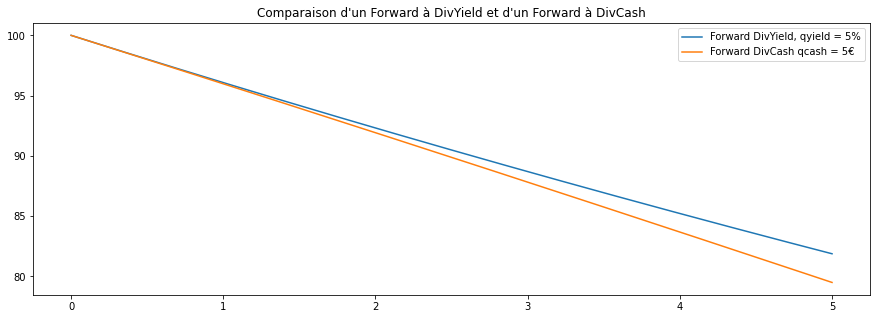

In [53]:
#Plot the Fwd in function of time diffusion
plt.figure(figsize=(15,5))
Time_vect = np.array([i/252 for i in range(252 * T + 1)])
plt.plot(Time_vect, Syield_vect, label="Forward DivYield, qyield = 5%")
plt.plot(Time_vect, Scash_vect, label="Forward DivCash qcash = 5€")
plt.title("Comparaison d'un Forward à DivYield et d'un Forward à DivCash")
plt.legend()
plt.show()

Conclusion : for an equivalent amount of nominal 5% vs 5€, the FixDiv models leads to a more aggressive forward

Then how to equlize forwards? In other words, what should be the divyield to match the forward of fixdiv model?

## 1.4 How to match Forwards?

In order to match forwards, let's first solve the differential equation governing FixDiv Forward

\begin{align}
{dF}(t,T) = r \cdot S_tdt-Q\cdot dt
\end{align}

Using the integrating factor method, this equation can be solved as:

\begin{align}
    {F}(t,T) = \mathrm{e}^{r\cdot T} \cdot (S_0 \cdot - \frac{qcash}{r} \cdot (1 - \mathrm{e}^{-r\cdot t}))
\end{align}

This leads us to be able to retrieve the divyield that can match the fixdiv forward.

we obtain:

\begin{align}
     S_t \cdot \mathrm{e}^{(r-q)\cdot(T-t)} = \mathrm{e}^{r\cdot T} \cdot (S_0 \cdot - \frac{qcash}{r} \cdot (1 - \mathrm{e}^{-r\cdot t}))
\end{align}

which gives:

\begin{align}
    qyield^{*} = -\frac{ \ln(1-\frac{ qcash \cdot T\cdot \mathrm{e}^{-rT} }{S_0} ) }{T}
\end{align}

which gives us, with our input data:

In [54]:
qyieldeq = -np.log( (S0-( qcash/r) * ( 1-np.exp(-r*T) ) ) /S0 )/T
print('qyieldeq = ', np.round(qyieldeq,4))

qyieldeq =  0.0559


Let's now check forwards are matching

In [55]:
#Defining some constants
S0 = 100
r = 0.01
qyield = qyieldeq
qcash = 5
T = 5

In [56]:
# Fwd with a DivYieldyield equivalent Model, with 3Y Maturity
factor = np.ones(252 * T)*np.exp((r-qyield)/252)
factor = np.concatenate( (np.array([S0]),factor), axis=0 )
Syield_vect = np.cumprod(factor)

In [57]:
#DivCash Model
Scash_vect = fwd_cashdiv(S0, T, r, qcash)

In [58]:
print("Forward DivYield Equivalent = ",np.round(Syield_vect[-1],2))
print("Forward DivCash = ",np.round(Scash_vect[-1],2))

Forward DivYield Equivalent =  79.49
Forward DivCash =  79.49


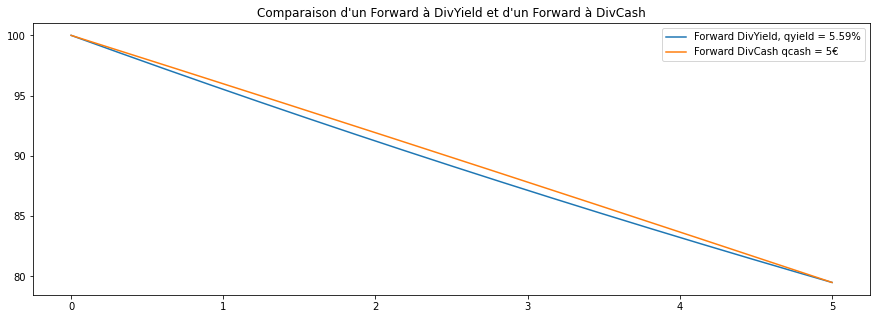

In [59]:
#Plot the Fwd in function of time diffusion
plt.figure(figsize=(15,5))
Time_vect = np.array([i/252 for i in range(252 * T + 1)])
plt.plot(Time_vect, Syield_vect, label="Forward DivYield, qyield = " + str(100 * np.round(qyieldeq,4)) + "%")
plt.plot(Time_vect, Scash_vect, label="Forward DivCash qcash = 5€")
plt.title("Comparaison d'un Forward à DivYield et d'un Forward à DivCash")
plt.legend()
plt.show()

Now that we have our first intuitions about forwards, let's move to options pricing

# 2. Implications in terms of Options Valuation

Let's first create a standard BS simulator

In [60]:
def BS_Generator(spot_price, maturity, r, q, sigma, nb_paths):
  
  rnd_matrix = np.random.normal(0, 1, (nb_paths, maturity * 252)) * sigma / np.sqrt(252) + (r - q - (sigma**2) / 2) / 252
  exp_rnd_matrix = np.exp(rnd_matrix) 
  MC_simulator = np.cumprod(np.c_[np.ones(nb_paths) * spot_price, exp_rnd_matrix], axis=1)

  return pd.DataFrame(MC_simulator)

In [61]:
def BS_Generator_DivCash(spot_price, maturity, r, qcash, sigma, nb_paths):
    rnd_matrix = np.random.normal(0, 1, (nb_paths, maturity * 252)) * sigma / np.sqrt(252) + (r - (sigma**2) / 2) / 252
    exp_rnd_matrix = np.exp(rnd_matrix)
    S0 = np.ones(nb_paths) * spot_price
    simulation = np.c_[np.ones(nb_paths) * spot_price, exp_rnd_matrix]
    MC_simulator = simulation
    for i in range(nb_paths):
        for j in range(1,maturity*252+1):
            MC_simulator[i,j] = simulation[i][j-1] * simulation[i][j] -qcash/252
            
    return pd.DataFrame(MC_simulator)

In [62]:
#check that the spot prices at maturity look coherent through an example

spot_price = 100
maturity = 5
r = 0.01
q = 0.04
qcash = 5
sigma = 0.2
nb_paths = 10000

BS_spot_diffusion = BS_Generator(spot_price, maturity, r, q, sigma, nb_paths)

In [63]:
#display the data frame at different dates (every 252/4 dates means every quarter)
BS_spot_diffusion.iloc[:,[ i for i in BS_spot_diffusion.columns if i % int( 252 / 4 )==0 ]]

,0,63,126,189,252,315,378,441,504,567,...,693,756,819,882,945,1008,1071,1134,1197,1260
0,100.0,90.276810,76.075551,70.944179,75.992928,75.901707,73.137531,79.028343,86.068572,89.216629,...,75.137050,71.180123,76.577798,68.470721,72.116706,69.907649,76.217901,60.190541,44.046968,38.402936
1,100.0,100.064445,96.922679,88.619069,70.125456,68.449986,64.897330,57.570639,55.050092,72.406889,...,61.587046,57.638426,61.859398,72.206793,76.744947,70.412015,67.365456,73.828038,71.769505,73.131743
2,100.0,118.901064,115.225629,115.622618,100.516028,88.462928,85.877412,78.104169,79.890768,80.707092,...,91.615478,76.784944,69.541969,76.072153,80.586384,77.794808,77.667392,69.524255,73.054380,62.345575
3,100.0,103.830639,114.324865,99.709987,92.303515,82.552311,89.729489,92.777286,92.373840,93.848317,...,80.690421,82.906146,90.677947,96.160994,100.376278,94.364667,89.093160,85.438110,86.314995,78.990584
4,100.0,87.118627,80.996236,95.935675,85.126621,98.519337,91.186471,91.807732,89.398081,79.500163,...,83.591142,66.918439,56.987008,59.196840,56.366943,57.645501,49.485950,53.560021,50.944953,59.749373
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,100.0,97.834525,78.512705,81.675981,75.220292,72.312055,66.667932,63.557834,51.109198,39.540507,...,34.208368,33.998996,34.826830,36.554355,30.943981,29.135743,33.464418,32.323646,31.471244,31.064880
9996,100.0,101.354754,94.817789,76.076142,70.811073,62.298671,65.165866,64.469580,62.985913,67.382708,...,65.851377,59.996242,53.877804,54.600331,62.668084,68.009186,62.504832,57.780175,59.856330,58.259571
9997,100.0,105.983731,97.055716,102.394778,99.247331,103.832635,109.779975,115.898442,99.444277,94.085459,...,117.082782,100.003653,98.012387,97.388298,99.751244,90.197107,81.123745,74.362623,68.414607,70.125990
9998,100.0,90.305289,93.469831,90.390802,85.665567,72.747484,70.081986,68.237061,69.123751,62.825233,...,56.092813,64.827778,75.648224,68.934534,71.948814,68.221683,68.347360,80.169751,94.247664,87.372846


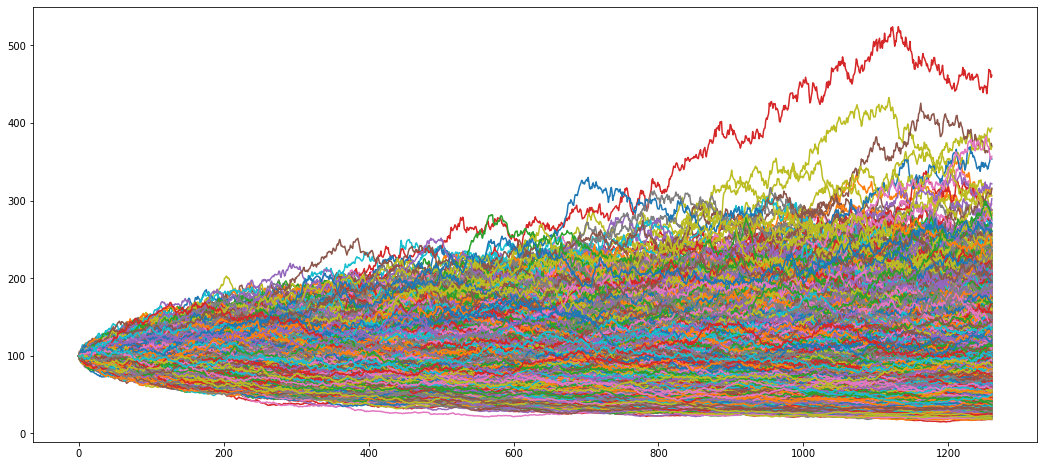

In [64]:
#Plot the spot diffusion
plt.figure(figsize=(18,8))
plt.plot(BS_spot_diffusion.T)
plt.show()

In [65]:
BS_spot_diffusion_divcash = BS_Generator_DivCash(spot_price, maturity, r, qcash, sigma, nb_paths)

In [66]:
#display the data frame at different dates (every 252/4 dates means every quarter)
BS_spot_diffusion_divcash.iloc[:,[ i for i in BS_spot_diffusion.columns if i % int( 252 / 4 )==0 ]]

,0,63,126,189,252,315,378,441,504,567,...,693,756,819,882,945,1008,1071,1134,1197,1260
0,100.0,98.028789,90.022806,83.689388,87.737990,80.543548,96.877508,94.534149,94.658086,114.150138,...,100.204822,86.489219,82.908039,83.938561,88.813063,96.758173,111.747232,124.275625,103.584576,111.639236
1,100.0,92.320692,99.257016,101.754513,92.700802,97.580183,113.268535,115.059793,96.785289,96.577702,...,86.114080,73.300229,72.051227,70.080441,72.527348,64.855426,61.250004,54.662682,50.675588,43.883455
2,100.0,92.541976,103.780019,112.012538,106.500406,118.168638,113.405124,125.350921,122.277041,100.997390,...,90.906139,91.975240,89.140665,101.225272,114.716531,148.518163,151.090374,141.759808,130.838133,128.207681
3,100.0,92.029232,80.250054,78.912461,69.225919,70.470663,73.842251,57.320820,73.557265,74.729831,...,72.898204,77.345551,85.813323,94.175246,90.152295,99.388119,91.089768,81.684745,86.558304,92.232775
4,100.0,94.807577,68.813860,60.661472,55.300380,50.760633,57.676499,63.682417,67.186931,70.966928,...,75.849322,89.875625,97.906679,101.507549,110.150988,116.397095,113.466526,113.962964,102.430929,103.731516
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,100.0,89.387971,79.997948,87.464218,88.214781,72.343964,66.074221,64.548299,77.012493,75.710051,...,64.446083,57.541748,61.103547,53.430462,46.034117,43.336306,43.961371,42.399991,38.227484,36.895816
9996,100.0,95.218377,91.630418,103.406658,103.701403,104.747602,103.865309,88.011521,86.249756,77.209031,...,71.190374,70.733430,70.535956,66.276144,74.525589,80.905491,85.645658,67.170413,74.669662,81.131371
9997,100.0,96.524746,81.900219,78.714562,90.981578,85.479370,80.588244,74.181370,79.728565,86.693112,...,70.048436,76.228975,83.924060,88.167740,86.470743,86.125074,77.828180,58.495173,59.466685,56.212764
9998,100.0,96.843221,88.947701,105.261743,97.302341,88.913733,71.617138,79.544707,69.958509,69.732960,...,65.157408,60.017249,55.954109,54.957486,57.016540,47.767612,48.358590,49.755747,43.311231,43.692987


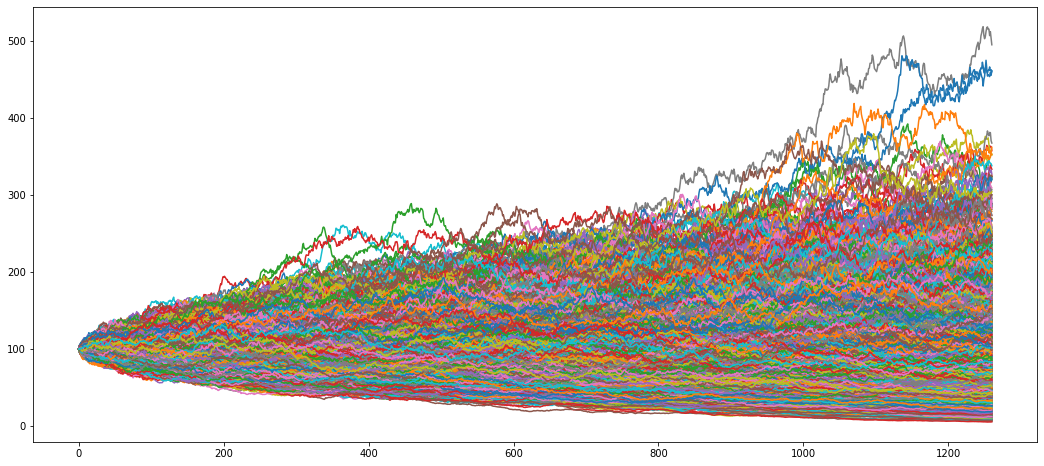

In [67]:
#Plot the spot diffusion
plt.figure(figsize=(18,8))
plt.plot(BS_spot_diffusion_divcash.T)
plt.show()

In [68]:
# Sort DivCash diffsusion in ascending terms
np.sort(BS_spot_diffusion_divcash.iloc[:,-1])

array([  5.51745784,   6.44794595,   6.60651082, ..., 459.59536707,
       460.93020792, 494.52620198])

In [69]:
# Sort DivYield diffsusion in ascending terms
np.sort(BS_spot_diffusion.iloc[:,-1])

array([ 17.96800475,  18.60929368,  19.03478378, ..., 370.443027  ,
       393.37710906, 461.51886546])

In [70]:
avg_spot_divyield = np.round(np.mean(BS_spot_diffusion.iloc[:,-1]))
avg_spot_divcash = np.round(np.mean(BS_spot_diffusion_divcash.iloc[:,-1]))
print("avg_spot_divyield = ", avg_spot_divyield, " avg_spot_divcash = ",avg_spot_divcash )

avg_spot_divyield =  86.0  avg_spot_divcash =  79.0


In terms of returns, we have :

In [71]:
avg_returns_divyield = np.mean((BS_spot_diffusion.iloc[:,-1]-100)/100)
avg_returns_divcash = np.mean((BS_spot_diffusion_divcash.iloc[:,-1]-100)/100)
print("avg_returns_divyield = ", np.round(avg_returns_divyield,2), " avg_returns_divcash = ",np.round(avg_returns_divcash,2))

avg_returns_divyield =  -0.14  avg_returns_divcash =  -0.21


To show that those empirical means are significantly different we can do an hypothesis test at the 5% threshold. Let's test

\begin{align}
    \text{H0: } & \overline{S_{divyield}}=\overline{S_{divcash}}
    \end{align}

where, for each model,

\begin{align}
    \overline{S_{T,n}} =  \sum_{i=1}^n S_{T, i}
    \end{align}

We know that the divyield spot diffusion model follows a Normal distribution

\begin{align}
            \frac{dS_t}{ S_t} \sim \mathcal{N}((r-q)dt,\,\sigma^{2}dt)
    \end{align}

On a au seuil 5% :

\begin{align}
           P( - 1.96  < \frac{\overline{S_{divyield}}-\overline{S_{divcash}}}{\frac{\\sigma *T}{\sqrt{n}}} < 1.96)
    \end{align}

with our data, we have 

\begin{align}
\frac{\overline{S_{divyield}}-\overline{S_{divcash}}}{\frac{\\sigma *T}{\sqrt{n}}} = \frac{87-80}{\frac{0.2\cdot 5}{\sqrt(10000)}}
 \end{align}

In [72]:
result = (avg_spot_divyield -avg_spot_divcash)/(sigma*maturity/np.sqrt(nb_paths))
print("observed quantile = ", np.round(result,2))

observed quantile =  700.0


\begin{align}
\frac{\overline{S_{divyield}}-\overline{S_{divcash}}}{\frac{\\sigma *T}{\sqrt{n}}} = 700>1.96
 \end{align}

Conclusion: we reject HO and conclude that empirical means are significantly different, and more precisely that DivYield model outputs significantly superior underlying levels at maturity

With the same reasonning, we can show that volatility in both models is also different:

In [73]:
sigma_divyield = np.std((BS_spot_diffusion.iloc[:,-1]-100)/(100*sqrt(maturity)))
sigma_divcash = np.std((BS_spot_diffusion_divcash.iloc[:,-1]-100)/(100*sqrt(maturity)))
print("std_returns_divyield = ", np.round(sigma_divyield,4), " std_returns_divcash = ",np.round(sigma_divcash,4))

std_returns_divyield =  0.1768  std_returns_divcash =  0.1965


Indeed we have a higher volatility in the div cash model. This can be explain by the effect of dividends on Forwards. In a DivYield model,when spot is high, dividends are also high which has a downside impact on the forward. Symetrically, when spot is low the dividend will also be low, which has an upside impact on the forward. Those effects are not existing in the FixDiv model.

Let's finally compute the PDI Valuation in both models

\begin{align}
            PDIPayoff = \max(K - S_T,0) \cdot \mathbb{1}_{S_T < PDIBarrier}
\end{align}

In [74]:
K=100
PDIBarrier = 75
BS_spot_diffusion_last_date = BS_spot_diffusion.iloc[:,-1]
BS_spot_diffusion_divcash_last_date = BS_spot_diffusion_divcash.iloc[:,-1]

In [75]:
PDI_Divyield = 1/nb_paths * np.sum(K-BS_spot_diffusion_last_date[BS_spot_diffusion_last_date<PDIBarrier])
PDI_DivCash = 1/nb_paths * np.sum(K-BS_spot_diffusion_divcash_last_date[BS_spot_diffusion_divcash_last_date<PDIBarrier])

print("PDI_Divyield = ", np.round(PDI_Divyield,2), " PDI_DivCash = ",np.round(PDI_DivCash,2) )

PDI_Divyield =  20.85  PDI_DivCash =  27.49


We can observe a gap of 6.64 Euros, in the valuation of the PDI, which means that in the context of an autocall, the customer being short PDI, he can buy for 6.64 Euros worth of digital coupons.